# Sup-not-MIWAE Demo: Supervised Learning with MNAR Data

This notebook demonstrates the advantage of **sup-not-MIWAE** for prediction with Missing Not At Random (MNAR) data.

## Comparison Setup

We compare three approaches:

1. **Two-Stage (not-MIWAE + Classifier)**: First impute missing values with not-MIWAE, then train a classifier
2. **Sup-not-MIWAE**: Joint model that marginalizes over missing data for prediction
3. **Oracle**: Trained on complete data (no missingness) - upper bound

**Key insight**: Sup-not-MIWAE properly marginalizes over missing values during prediction, avoiding the approximation error of two-stage approaches.

## Setup

In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torchvision-0.20.1%2Bcu121-cp310-cp310-win_amd64.whl (6.1 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchaudio-2.5.1%2Bcu121-cp310-cp310-win_amd64.whl (4.1 MB)


In [1]:
import sys
import os
sys.path.insert(0, os.path.dirname(os.path.abspath('')))

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report
from sklearn.datasets import load_breast_cancer, load_iris
from scipy.special import expit as sigmoid
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from models.notmiwae import NotMIWAE
from models.supnotmiwae import SupNotMIWAE
from models.supmiwae import SupMIWAE

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Helper Functions

In [2]:
def introduce_mnar_missing(X, missing_rate=0.3, mechanism='selfmasking', mode='first_half', subset_prob=0.5, seed=42):
    """
    Introduce MNAR missingness where high values are more likely to be missing.

    Modes:
    - 'first_half': apply MNAR to the first half of features (default)
    - 'all': apply MNAR to all features
    - 'random_subsets': per-sample random subset of features eligible (controlled by subset_prob)

    Args:
        X: Data array (n_samples, n_features)
        missing_rate: Target missing rate
        mechanism: 'selfmasking' (each feature depends on itself)
        mode: MNAR application mode
        subset_prob: Probability a feature is eligible (random_subsets)
        seed: Random seed

    Returns:
        X_filled: Data with missing values replaced by 0
        mask: Binary mask (1=observed, 0=missing)
    """
    rng = np.random.default_rng(seed)
    X_filled = X.copy()
    mask = np.ones_like(X)
    n_samples, n_features = X.shape

    # Determine eligibility per feature or per sample
    if mode == 'first_half':
        eligible = np.zeros(n_features, dtype=bool)
        eligible[: n_features // 2] = True
        eligible_matrix = np.tile(eligible, (n_samples, 1))
    elif mode == 'all':
        eligible_matrix = np.ones((n_samples, n_features), dtype=bool)
    elif mode == 'random_subsets':
        eligible_matrix = rng.random((n_samples, n_features)) < subset_prob
    else:
        raise ValueError("mode must be one of {'first_half','all','random_subsets'}")

    # Self-masking sigmoid parameters
    a = -3.0  # Negative slope: higher x -> lower p(observed)

    # Calibrate b to achieve target missing rate on eligible positions
    b_values = np.linspace(-2, 2, 25)
    best_b = 0
    best_diff = float('inf')

    for b_test in b_values:
        temp_mask = np.ones_like(X)
        probs_observed = sigmoid(a * X + b_test)
        # only apply to eligible positions
        temp_mask = np.where(eligible_matrix, np.random.binomial(1, probs_observed), 1)
        current_rate = 1 - temp_mask.mean()
        if abs(current_rate - missing_rate) < best_diff:
            best_diff = abs(current_rate - missing_rate)
            best_b = b_test

    # Apply with best b
    probs_observed = sigmoid(a * X + best_b)
    mask = np.where(eligible_matrix, np.random.binomial(1, probs_observed), 1)
    X_filled = X * mask  # Zero out missing

    actual_rate = 1 - mask.mean()
    print(f"Target missing rate: {missing_rate:.1%}, Actual: {actual_rate:.1%}")
    if mode == 'first_half':
        print(f"Missing values per feature (first half): {(1 - mask[:, :n_features//2].mean(axis=0))}")

    return X_filled, mask

In [3]:
def plot_missing_pattern(X_original, mask, feature_names, dataset_name):
    """Visualize the MNAR missing pattern."""
    n_features = X_original.shape[1]
    fig, axes = plt.subplots(1, min(4, n_features // 2), figsize=(16, 4))
    if n_features // 2 == 1:
        axes = [axes]
    
    for i in range(min(4, n_features // 2)):
        observed = X_original[mask[:, i] == 1, i]
        missing = X_original[mask[:, i] == 0, i]
        
        axes[i].hist(observed, bins=30, alpha=0.6, label='Observed', color='blue', density=True)
        axes[i].hist(missing, bins=30, alpha=0.6, label='Missing (true values)', color='red', density=True)
        axes[i].set_xlabel(f'{feature_names[i]}')
        axes[i].set_ylabel('Density')
        axes[i].set_title(f'{feature_names[i]}\nMissing rate: {(1 - mask[:, i].mean()):.1%}')
        axes[i].legend()
        axes[i].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle(f'{dataset_name}: MNAR Pattern (High Values Missing)', y=1.02, fontsize=14, fontweight='bold')
    plt.show()

## 2. Load and Prepare Data

We'll use the **Pima Indians Diabetes on OpenML** dataset for binary classification.

In [4]:
from sklearn.datasets import fetch_openml

In [5]:
# Load dataset
cancer = load_breast_cancer()
X_full = cancer.data.astype(np.float32)
y_full = cancer.target.astype(np.int64)

print(f"Dataset: {X_full.shape[0]} samples, {X_full.shape[1]} features")
print(f"Classes: {np.unique(y_full)} (0=malignant, 1=benign)")
print(f"Class distribution: {np.bincount(y_full)}")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.3, random_state=42, stratify=y_full
)

# Standardize
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train).astype(np.float32)
X_test_std = scaler.transform(X_test).astype(np.float32)

print(f"\nTrain: {X_train_std.shape[0]} samples")
print(f"Test: {X_test_std.shape[0]} samples")

Dataset: 569 samples, 30 features
Classes: [0 1] (0=malignant, 1=benign)
Class distribution: [212 357]

Train: 398 samples
Test: 171 samples


In [6]:
# Load dataset (Pima Indians Diabetes)
diabetes = fetch_openml("diabetes", version=1, as_frame=False)
X_full = diabetes.data.astype(np.float32)

# Convert string labels → {0,1}
y_str = diabetes.target
y_full = (y_str == "tested_positive").astype(np.int64)

print(f"Dataset: {X_full.shape[0]} samples, {X_full.shape[1]} features")
print(f"Classes: {np.unique(y_full)} (0=no diabetes, 1=diabetes)")
print(f"Class distribution: {np.bincount(y_full)}")

# Train/test split (keep stratification)
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.3, random_state=42, stratify=y_full
)

# Standardize
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train).astype(np.float32)
X_test_std = scaler.transform(X_test).astype(np.float32)

print(f"\nTrain: {X_train_std.shape[0]} samples")
print(f"Test: {X_test_std.shape[0]} samples")

Dataset: 768 samples, 8 features
Classes: [0 1] (0=no diabetes, 1=diabetes)
Class distribution: [500 268]

Train: 537 samples
Test: 231 samples


In [24]:
# Load Covertype
data = fetch_openml("covertype", as_frame=False)
X_full = data.data.astype(np.float32)
y_full = data.target.astype(np.int64) - 1  # classes 1..7 → 0..6

# Optional: downsample to ~50k
rng = np.random.default_rng(42)
idx = rng.choice(len(X_full), size=20000, replace=False)
X_full, y_full = X_full[idx], y_full[idx]

print(f"Dataset: {X_full.shape[0]} samples, {X_full.shape[1]} features")
print(f"Classes: {np.unique(y_full)}")

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.3, random_state=42, stratify=y_full
)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train).astype(np.float32)
X_test_std = scaler.transform(X_test).astype(np.float32)

c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\datasets\_openml.py:328: UserWarning: Multiple active versions of the dataset matching the name covertype exist. Versions may be fundamentally different, returning version 3. Available versions:
- version 3, status: active
  url: https://www.openml.org/search?type=data&id=150
- version 1, status: active
  url: https://www.openml.org/search?type=data&id=180

  warn(warning_msg)


Dataset: 20000 samples, 54 features
Classes: [0 1 2 3 4 5 6]


## 3. Introduce MNAR Missingness

We introduce missingness where **high values are more likely to be missing** for the first half of features.

Target missing rate: 30.0%, Actual: 31.2%


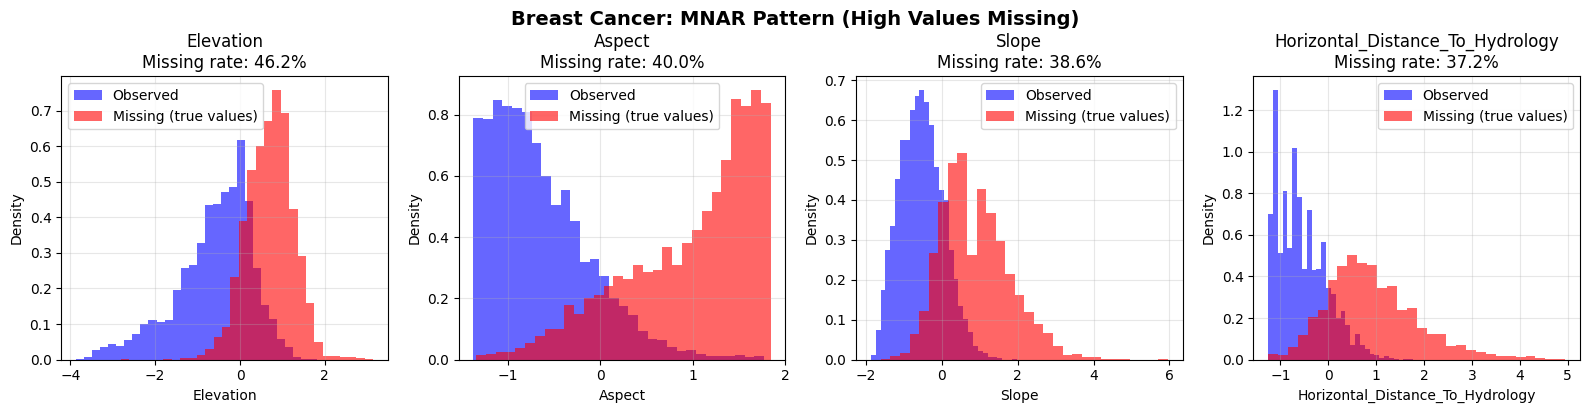

In [25]:
# Introduce MNAR missingness to training data
X_train_filled, mask_train = introduce_mnar_missing(X_train_std, missing_rate=0.3, mode='all')

# Visualize missing pattern
plot_missing_pattern(X_train_std, mask_train, data.feature_names, 'Breast Cancer')

In [26]:
# Convert to tensors
X_train_t = torch.tensor(X_train_filled, dtype=torch.float32)
mask_train_t = torch.tensor(mask_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)

X_test_t = torch.tensor(X_test_std, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

print(f"Training data shape: {X_train_t.shape}")
print(f"Training labels shape: {y_train_t.shape}")

Training data shape: torch.Size([14000, 54])
Training labels shape: torch.Size([14000])


## 4. Method 1: Two-Stage (not-MIWAE Imputation + Classifier)

First, train not-MIWAE to impute missing values, then train a separate classifier.

In [27]:
# Train not-MIWAE for imputation
print("Training not-MIWAE for imputation...")
notmiwae = NotMIWAE(
    input_dim=X_train_std.shape[1],
    latent_dim=20,
    hidden_dim=128,
    n_samples=20,
    out_dist='gauss',
    missing_process='selfmasking_known',
    signs=torch.ones(X_train_std.shape[1])  # High values missing
).to(device)

train_dataset = TensorDataset(X_train_t, mask_train_t)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

optimizer = torch.optim.Adam(notmiwae.parameters(), lr=1e-3)

notmiwae.train()
for epoch in tqdm(range(100), desc="Training not-MIWAE"):
    total_loss = 0
    for x, s in train_loader:
        x, s = x.to(device), s.to(device)
        optimizer.zero_grad()
        out = notmiwae(x, s)
        loss = out['loss']
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    if (epoch + 1) % 25 == 0:
        pass  # tqdm will show progress

print("✓ not-MIWAE training complete")

Training not-MIWAE for imputation...


Training not-MIWAE: 100%|██████████| 100/100 [05:24<00:00,  3.24s/it]

✓ not-MIWAE training complete


In [28]:
# Impute training data
print("\nImputing training data...")
notmiwae.eval()
with torch.no_grad():
    X_train_imputed = notmiwae.impute(
        X_train_t.to(device), 
        mask_train_t.to(device), 
        n_samples=100
    ).cpu()

print(f"Imputed data shape: {X_train_imputed.shape}")
print("✓ Imputation complete")


Imputing training data...
Imputed data shape: torch.Size([14000, 54])
✓ Imputation complete


In [29]:
# Train classifier on imputed data
print("\nTraining classifier on imputed data...")

class SimpleClassifier(nn.Module):
    """
    Low-capacity classifier:
      - Binary: logistic regression (num_classes=1)
      - Multiclass: softmax regression (num_classes > 1)
    """

    def __init__(self, input_dim, hidden_dim=128, num_classes=2):
        super().__init__()
        # hidden_dim kept only for API compatibility
        self.net = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.net(x)

two_stage_classifier = SimpleClassifier(X_train_std.shape[1], num_classes=7).to(device)

imputed_dataset = TensorDataset(X_train_imputed, y_train_t)
imputed_loader = DataLoader(imputed_dataset, batch_size=64, shuffle=True)

optimizer = torch.optim.Adam(two_stage_classifier.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

two_stage_classifier.train()
for epoch in tqdm(range(100), desc="Training two-stage classifier"):
    total_loss = 0
    for x, y in imputed_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = two_stage_classifier(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

print("✓ Two-stage classifier training complete")


Training classifier on imputed data...


Training two-stage classifier:   0%|          | 0/100 [00:00<?, ?it/s]

Training two-stage classifier: 100%|██████████| 100/100 [00:55<00:00,  1.80it/s]

✓ Two-stage classifier training complete


## 5. Method 2: Sup-not-MIWAE (Joint Model)

Train sup-not-MIWAE which jointly models data, labels, and missingness.

In [30]:
print("Training sup-not-MIWAE (joint model)...")

supnotmiwae = SupNotMIWAE(
    input_dim=X_train_std.shape[1],
    latent_dim=20,
    hidden_dim=128, # not used since we simplifed capacity
    n_samples=20,
    out_dist='gauss',
    missing_process='selfmasking_known',
    y_dim=7,  # Binary classification
    task='classification',
    signs=torch.ones(X_train_std.shape[1])  # High values missing
).to(device)

supervised_dataset = TensorDataset(X_train_t, mask_train_t, y_train_t)
supervised_loader = DataLoader(supervised_dataset, batch_size=64, shuffle=True)

optimizer = torch.optim.Adam(supnotmiwae.parameters(), lr=1e-3)

supnotmiwae.train()
for epoch in tqdm(range(100), desc="Training sup-not-MIWAE"):
    total_loss = 0
    for x, s, y in supervised_loader:
        x, s, y = x.to(device), s.to(device), y.to(device)
        optimizer.zero_grad()
        out = supnotmiwae(x, s, y)
        loss = out['loss']
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

print("✓ sup-not-MIWAE training complete")

Training sup-not-MIWAE (joint model)...


Training sup-not-MIWAE: 100%|██████████| 100/100 [06:00<00:00,  3.61s/it]

✓ sup-not-MIWAE training complete


In [31]:

# Introduce same MNAR pattern to test set (needed for baseline preparation)
X_test_filled, mask_test = introduce_mnar_missing(X_test_std, missing_rate=0.3, mode='all')

X_test_filled_t = torch.tensor(X_test_filled, dtype=torch.float32)
mask_test_t = torch.tensor(mask_test, dtype=torch.float32)

print("✓ Test set MNAR missingness introduced")


Target missing rate: 30.0%, Actual: 31.2%
✓ Test set MNAR missingness introduced


In [56]:

# Baseline 1: Mean Imputation + MLP (Simple approach)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

print("Training Mean Imputation + Logistic Regrression baseline...")

# Prepare mean-imputed train/test
imputer_mean = SimpleImputer(strategy='mean')
X_train_mean = imputer_mean.fit_transform(np.where(mask_train == 1, X_train_std, np.nan))
X_test_mean = imputer_mean.transform(np.where(mask_test == 1, X_test_std, np.nan))

mlp_mean = LogisticRegression(max_iter=100, solver='lbfgs')
mlp_mean.fit(X_train_mean, y_train)

print("✓ Mean+Logistic Regression baseline training complete")


Training Mean Imputation + Logistic Regrression baseline...
✓ Mean+Logistic Regression baseline training complete


c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [58]:
# Baseline 2: MICE + MLP (More sophisticated imputation)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

print("Training MICE + MLP baseline...")

try:
    imputer_mice = IterativeImputer(random_state=42, max_iter=10, verbose=0)
    X_train_mice = imputer_mice.fit_transform(np.where(mask_train == 1, X_train_std, np.nan))
    X_test_mice = imputer_mice.transform(np.where(mask_test == 1, X_test_std, np.nan))

    mlp_mice = LogisticRegression(max_iter=100, solver='lbfgs')
    mlp_mice.fit(X_train_mice, y_train)
    
    print("✓ MICE+Logistic Regression baseline training complete")
    mice_available = True
except Exception as e:
    print(f"⚠ MICE baseline skipped: {e}")
    mice_available = False


Training MICE + MLP baseline...


c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


✓ MICE+Logistic Regression baseline training complete


c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 5b. Method 2b: SupMIWAE (Without Missing Process Model)

SupMIWAE ignores the missingness mechanism and treats missing data as MCAR. This is a useful comparison baseline.

In [34]:
print("Training SupMIWAE (baseline: ignores missing mechanism)...")

supmiwae = SupMIWAE(
    input_dim=X_train_std.shape[1],
    latent_dim=20,
    hidden_dim=128, # not used -> reduce capacity
    n_samples=20,
    out_dist='gauss',
    y_dim=7,  # Binary classification
    task='classification'
).to(device)

optimizer = torch.optim.Adam(supmiwae.parameters(), lr=1e-3)

supmiwae.train()
for epoch in tqdm(range(100), desc="Training SupMIWAE"):
    total_loss = 0
    for x, s, y in supervised_loader:
        x, s, y = x.to(device), s.to(device), y.to(device)
        optimizer.zero_grad()
        out = supmiwae(x, s, y)
        loss = out['loss']
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

print("✓ SupMIWAE training complete")

Training SupMIWAE (baseline: ignores missing mechanism)...


Training SupMIWAE: 100%|██████████| 100/100 [04:49<00:00,  2.89s/it]

✓ SupMIWAE training complete


## 6. Method 3: Oracle (No Missing Data)

Train a classifier on complete data as an upper bound.

In [35]:
print("Training oracle classifier (no missing data)...")

oracle_classifier = SimpleClassifier(X_train_std.shape[1], num_classes=7).to(device)

X_train_complete_t = torch.tensor(X_train_std, dtype=torch.float32)
oracle_dataset = TensorDataset(X_train_complete_t, y_train_t)
oracle_loader = DataLoader(oracle_dataset, batch_size=64, shuffle=True)

optimizer = torch.optim.Adam(oracle_classifier.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

oracle_classifier.train()
for epoch in tqdm(range(100), desc="Training oracle classifier"):
    total_loss = 0
    for x, y in oracle_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = oracle_classifier(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

print("✓ Oracle classifier training complete")

Training oracle classifier (no missing data)...


Training oracle classifier: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]

✓ Oracle classifier training complete


## 7. Evaluation on Test Set

Now let's introduce the same MNAR missingness to the test set and evaluate all three methods. Additionally, we report ROC AUC (standard for Breast Cancer).

In [36]:
# (Test MNAR already introduced in cell above - just use existing variables)
print("Using test set with MNAR missingness from previous cell...")


Using test set with MNAR missingness from previous cell...


In [59]:
print("=" * 80)
print("EVALUATION ON TEST SET WITH MNAR MISSINGNESS")
print("=" * 80)

from sklearn.metrics import roc_auc_score

# =========================
# Baseline 0: Mean + MLP
# =========================
print("\n0. Mean Imputation + MLP (baseline)...")

y_pred_mean = mlp_mean.predict(X_test_mean)
y_proba_mean = mlp_mean.predict_proba(X_test_mean)  # (N, C)

acc_mean = accuracy_score(y_test, y_pred_mean)
auc_mean = roc_auc_score(
    y_test,
    y_proba_mean,
    multi_class="ovr",
    average="macro"
)

print(f"   Accuracy: {acc_mean:.4f} | AUC: {auc_mean:.4f}")

# =========================
# Baseline 0b: MICE + MLP
# =========================
if mice_available:
    print("\n0b. MICE + MLP (optional baseline)...")

    y_pred_mice = mlp_mice.predict(X_test_mice)
    y_proba_mice = mlp_mice.predict_proba(X_test_mice)

    acc_mice = accuracy_score(y_test, y_pred_mice)
    auc_mice = roc_auc_score(
        y_test,
        y_proba_mice,
        multi_class="ovr",
        average="macro"
    )

    print(f"   Accuracy: {acc_mice:.4f} | AUC: {auc_mice:.4f}")

# =========================
# Method 1: Two-stage
# =========================
print("\n1. Two-Stage (not-MIWAE imputation + classifier)...")

notmiwae.eval()
two_stage_classifier.eval()

with torch.no_grad():
    X_test_imputed = notmiwae.impute(
        X_test_filled_t.to(device),
        mask_test_t.to(device),
        n_samples=100
    )
    logits_twostage = two_stage_classifier(X_test_imputed)
    probs_twostage = torch.softmax(logits_twostage, dim=-1).cpu().numpy()
    preds_twostage = probs_twostage.argmax(axis=1)

acc_twostage = accuracy_score(y_test, preds_twostage)
auc_twostage = roc_auc_score(
    y_test,
    probs_twostage,
    multi_class="ovr",
    average="macro"
)

print(f"   Accuracy: {acc_twostage:.4f} | AUC: {auc_twostage:.4f}")

# =========================
# Method 2: Sup-not-MIWAE
# =========================
print("\n2. Sup-not-MIWAE (accounts for MNAR)...")

supnotmiwae.eval()
with torch.no_grad():
    probs_supnotmiwae = supnotmiwae.predict(
        X_test_filled_t.to(device),
        mask_test_t.to(device),
        n_samples=100
    ).cpu().numpy()

preds_supnotmiwae = probs_supnotmiwae.argmax(axis=1)

acc_supnotmiwae = accuracy_score(y_test, preds_supnotmiwae)
auc_supnotmiwae = roc_auc_score(
    y_test,
    probs_supnotmiwae,
    multi_class="ovr",
    average="macro"
)

print(f"   Accuracy: {acc_supnotmiwae:.4f} | AUC: {auc_supnotmiwae:.4f}")

# =========================
# Method 2b: SupMIWAE
# =========================
print("\n2b. SupMIWAE (ignores MNAR - baseline)...")

supmiwae.eval()
with torch.no_grad():
    probs_supmiwae = supmiwae.predict(
        X_test_filled_t.to(device),
        mask_test_t.to(device),
        n_samples=100
    ).cpu().numpy()

preds_supmiwae = probs_supmiwae.argmax(axis=1)

acc_supmiwae = accuracy_score(y_test, preds_supmiwae)
auc_supmiwae = roc_auc_score(
    y_test,
    probs_supmiwae,
    multi_class="ovr",
    average="macro"
)

print(f"   Accuracy: {acc_supmiwae:.4f} | AUC: {auc_supmiwae:.4f}")

# =========================
# Method 3: Oracle
# =========================
print("\n3. Oracle (no missing data - upper bound)...")

oracle_classifier.eval()
with torch.no_grad():
    logits_oracle = oracle_classifier(X_test_t.to(device))
    probs_oracle = torch.softmax(logits_oracle, dim=-1).cpu().numpy()

preds_oracle = probs_oracle.argmax(axis=1)

acc_oracle = accuracy_score(y_test, preds_oracle)
auc_oracle = roc_auc_score(
    y_test,
    probs_oracle,
    multi_class="ovr",
    average="macro"
)

print(f"   Accuracy: {acc_oracle:.4f} | AUC: {auc_oracle:.4f}")

# =========================
# Summary
# =========================
print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print(f"Oracle (no missing):           Acc {acc_oracle:.4f} | AUC {auc_oracle:.4f} ← upper bound")
print(f"Sup-not-MIWAE (MNAR-aware):    Acc {acc_supnotmiwae:.4f} | AUC {auc_supnotmiwae:.4f}")
print(f"SupMIWAE (ignores MNAR):       Acc {acc_supmiwae:.4f} | AUC {auc_supmiwae:.4f}")
print(f"Two-stage (impute + classify): Acc {acc_twostage:.4f} | AUC {auc_twostage:.4f}")
print(f"Mean+MLP (simple baseline):    Acc {acc_mean:.4f} | AUC {auc_mean:.4f}")
if mice_available:
    print(f"MICE+MLP (optional baseline):  Acc {acc_mice:.4f} | AUC {auc_mice:.4f}")

print(f"\nSup-not-MIWAE vs Mean+MLP (Acc): {acc_supnotmiwae - acc_mean:+.4f}")
print(f"Sup-not-MIWAE vs Mean+MLP (AUC): {auc_supnotmiwae - auc_mean:+.4f}")
print("=" * 80)


EVALUATION ON TEST SET WITH MNAR MISSINGNESS

0. Mean Imputation + MLP (baseline)...
   Accuracy: 0.5405 | AUC: 0.7927

0b. MICE + MLP (optional baseline)...
   Accuracy: 0.5425 | AUC: 0.7842

1. Two-Stage (not-MIWAE imputation + classifier)...
   Accuracy: 0.5445 | AUC: 0.7844

2. Sup-not-MIWAE (accounts for MNAR)...
   Accuracy: 0.5690 | AUC: 0.7998

2b. SupMIWAE (ignores MNAR - baseline)...
   Accuracy: 0.5970 | AUC: 0.8666

3. Oracle (no missing data - upper bound)...
   Accuracy: 0.7123 | AUC: 0.9306

SUMMARY
Oracle (no missing):           Acc 0.7123 | AUC 0.9306 ← upper bound
Sup-not-MIWAE (MNAR-aware):    Acc 0.5690 | AUC 0.7998
SupMIWAE (ignores MNAR):       Acc 0.5970 | AUC 0.8666
Two-stage (impute + classify): Acc 0.5445 | AUC 0.7844
Mean+MLP (simple baseline):    Acc 0.5405 | AUC 0.7927
MICE+MLP (optional baseline):  Acc 0.5425 | AUC 0.7842

Sup-not-MIWAE vs Mean+MLP (Acc): +0.0285
Sup-not-MIWAE vs Mean+MLP (AUC): +0.0071


## 8. Detailed Analysis

In [15]:
# Classification reports
print("\nDetailed Classification Reports:\n")

print("Two-Stage (impute + classify):")
print(classification_report(y_test, preds_twostage, target_names=['Malignant', 'Benign']))

print("\nSup-not-MIWAE (accounts for MNAR):")
print(classification_report(y_test, preds_supnotmiwae, target_names=['Malignant', 'Benign']))

print("\nSupMIWAE (ignores MNAR):")
print(classification_report(y_test, preds_supmiwae, target_names=['Malignant', 'Benign']))

print("\nOracle (no missing):")
print(classification_report(y_test, preds_oracle, target_names=['Malignant', 'Benign']))


Detailed Classification Reports:

Two-Stage (impute + classify):
              precision    recall  f1-score   support

   Malignant       0.93      0.97      0.95        64
      Benign       0.98      0.95      0.97       107

    accuracy                           0.96       171
   macro avg       0.95      0.96      0.96       171
weighted avg       0.96      0.96      0.96       171


Sup-not-MIWAE (accounts for MNAR):
              precision    recall  f1-score   support

   Malignant       0.95      0.97      0.96        64
      Benign       0.98      0.97      0.98       107

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171


SupMIWAE (ignores MNAR):
              precision    recall  f1-score   support

   Malignant       0.94      0.95      0.95        64
      Benign       0.97      0.96      0.97       107

    accuracy                           0.96       171


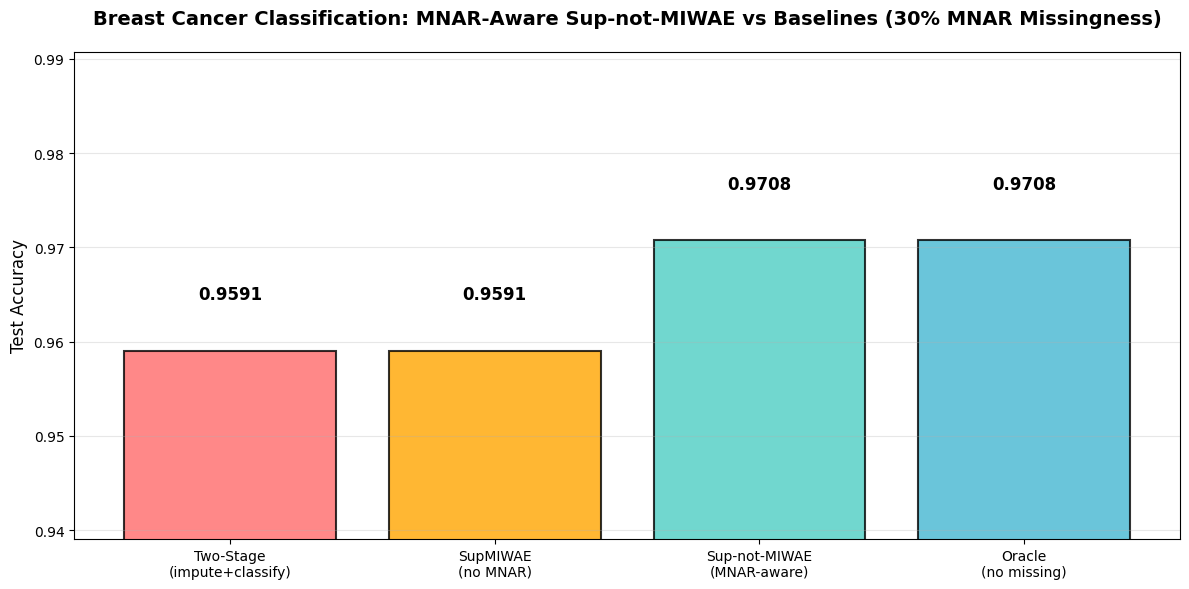


📊 Key Finding (Classification):
   Sup-not-MIWAE improves over two-stage by +0.0117 (+1.22%)
   SupMIWAE improves over two-stage by +0.0000
   Sup-not-MIWAE closes 100.0% of the gap to oracle


In [16]:
# Visualization: Comparison bar plot
methods = ['Two-Stage\n(impute+classify)', 'SupMIWAE\n(no MNAR)', 'Sup-not-MIWAE\n(MNAR-aware)', 'Oracle\n(no missing)']
accuracies = [acc_twostage, acc_supmiwae, acc_supnotmiwae, acc_oracle]
colors = ['#FF6B6B', '#FFA500', '#4ECDC4', '#45B7D1']

plt.figure(figsize=(12, 6))
bars = plt.bar(methods, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{acc:.4f}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Breast Cancer Classification: MNAR-Aware Sup-not-MIWAE vs Baselines (30% MNAR Missingness)', fontsize=14, fontweight='bold', pad=20)
plt.ylim([min(accuracies) - 0.02, max(accuracies) + 0.02])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Improvement over two-stage
improvement_sup = acc_supnotmiwae - acc_twostage
improvement_miwae = acc_supmiwae - acc_twostage
gap_closed = (acc_supnotmiwae - acc_twostage) / (acc_oracle - acc_twostage) * 100 if acc_oracle > acc_twostage else 0

print(f"\n📊 Key Finding (Classification):")
print(f"   Sup-not-MIWAE improves over two-stage by {improvement_sup:+.4f} ({improvement_sup/acc_twostage*100:+.2f}%)")
print(f"   SupMIWAE improves over two-stage by {improvement_miwae:+.4f}")
print(f"   Sup-not-MIWAE closes {gap_closed:.1f}% of the gap to oracle")

# Part 2: Regression Task (UCI, low-dimensional)

We now illustrate regression on smaller, lower-dimensional UCI datasets (e.g., Protein, Superconductivity, Boston, Wine-Red). We report test RMSE, and the regression heads parameterize a Gaussian (mean + log-variance) in the final layer.

## 11. Load Regression Dataset (UCI Wine-Red)

We use a small UCI dataset (Wine Quality - Red, 11 features) to reflect the low-dimensional UCI setting. Targets are treated as continuous for RMSE reporting.

In [60]:
from sklearn.datasets import fetch_openml

# Load UCI Wine Quality (Red) dataset
wine = fetch_openml(name="wine-quality-red", version=1, as_frame=True)
X_reg = wine.data.to_numpy().astype(np.float32)
y_reg = wine.target.to_numpy().astype(np.float32)

print(f"Dataset: {X_reg.shape[0]} samples, {X_reg.shape[1]} features")
print("Target: Wine quality score (treated as continuous)")
print(f"Target range: [{y_reg.min():.2f}, {y_reg.max():.2f}]")

# Train/test split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)

# Standardize features and target
scaler_X = StandardScaler()
X_train_reg_std = scaler_X.fit_transform(X_train_reg).astype(np.float32)
X_test_reg_std = scaler_X.transform(X_test_reg).astype(np.float32)

scaler_y = StandardScaler()
y_train_reg_std = scaler_y.fit_transform(y_train_reg.reshape(-1, 1)).flatten().astype(np.float32)
y_test_reg_std = scaler_y.transform(y_test_reg.reshape(-1, 1)).flatten().astype(np.float32)

print(f"\nTrain: {X_train_reg_std.shape[0]} samples")
print(f"Test: {X_test_reg_std.shape[0]} samples")

Dataset: 1599 samples, 11 features
Target: Wine quality score (treated as continuous)
Target range: [3.00, 8.00]

Train: 1119 samples
Test: 480 samples


## 12. Introduce MNAR Missingness

In [61]:
# Introduce MNAR missingness to training data
X_train_reg_filled, mask_train_reg = introduce_mnar_missing(X_train_reg_std, missing_rate=0.3, mode='all')

# Convert to tensors
X_train_reg_t = torch.tensor(X_train_reg_filled, dtype=torch.float32)
mask_train_reg_t = torch.tensor(mask_train_reg, dtype=torch.float32)
y_train_reg_t = torch.tensor(y_train_reg_std, dtype=torch.float32)

X_test_reg_t = torch.tensor(X_test_reg_std, dtype=torch.float32)
y_test_reg_t = torch.tensor(y_test_reg_std, dtype=torch.float32)

Target missing rate: 30.0%, Actual: 30.0%


## 13. Two-Stage: Imputation + Regressor

In [62]:
# Train not-MIWAE for imputation
print("Training not-MIWAE for imputation (regression)...")
notmiwae_reg = NotMIWAE(
    input_dim=X_train_reg_std.shape[1],
    latent_dim=10,
    hidden_dim=64,
    n_samples=20,
    out_dist='gauss',
    missing_process='selfmasking_known',
    signs=torch.ones(X_train_reg_std.shape[1])
).to(device)

train_dataset_reg = TensorDataset(X_train_reg_t, mask_train_reg_t)
train_loader_reg = DataLoader(train_dataset_reg, batch_size=256, shuffle=True)

optimizer = torch.optim.Adam(notmiwae_reg.parameters(), lr=1e-3)

notmiwae_reg.train()
for epoch in tqdm(range(50), desc="Training not-MIWAE (regression)"):
    total_loss = 0
    for x, s in train_loader_reg:
        x, s = x.to(device), s.to(device)
        optimizer.zero_grad()
        out = notmiwae_reg(x, s)
        loss = out['loss']
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

print("✓ not-MIWAE training complete")

Training not-MIWAE for imputation (regression)...


Training not-MIWAE (regression): 100%|██████████| 50/50 [00:03<00:00, 14.14it/s]

✓ not-MIWAE training complete


In [63]:
# Impute training data
print("\nImputing training data...")
notmiwae_reg.eval()
with torch.no_grad():
    X_train_reg_imputed = notmiwae_reg.impute(
        X_train_reg_t.to(device), 
        mask_train_reg_t.to(device), 
        n_samples=100
    ).cpu()

print("✓ Imputation complete")


Imputing training data...
✓ Imputation complete


In [64]:
# Train regressor on imputed data
print("\nTraining regressor on imputed data...")

class SimpleRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)  # mean and log-variance
        )
    
    def forward(self, x):
        out = self.net(x)
        mu = out[..., 0]
        logvar = out[..., 1]
        return mu, logvar

two_stage_regressor = SimpleRegressor(X_train_reg_std.shape[1], hidden_dim=64).to(device)

imputed_dataset_reg = TensorDataset(X_train_reg_imputed, y_train_reg_t)
imputed_loader_reg = DataLoader(imputed_dataset_reg, batch_size=256, shuffle=True)

optimizer = torch.optim.Adam(two_stage_regressor.parameters(), lr=1e-3)

def gaussian_nll(y_pred_mu, y_pred_logvar, y_true):
    # Negative log-likelihood for Gaussian with predicted mean/logvar
    return 0.5 * (y_pred_logvar + (y_true - y_pred_mu) ** 2 / torch.exp(y_pred_logvar) + np.log(2 * np.pi))

two_stage_regressor.train()
for epoch in tqdm(range(50), desc="Training two-stage regressor"):
    total_loss = 0
    for x, y in imputed_loader_reg:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        mu, logvar = two_stage_regressor(x)
        loss = gaussian_nll(mu, logvar, y).mean()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

print("✓ Two-stage regressor training complete")


Training regressor on imputed data...


Training two-stage regressor: 100%|██████████| 50/50 [00:00<00:00, 53.06it/s]

✓ Two-stage regressor training complete


## 14. Sup-not-MIWAE for Regression

In [65]:
print("Training sup-not-MIWAE (regression)...")

supnotmiwae_reg = SupNotMIWAE(
    input_dim=X_train_reg_std.shape[1],
    latent_dim=10,
    hidden_dim=64,
    n_samples=20,
    out_dist='gauss',
    missing_process='selfmasking_known',
    y_dim=1,
    task='regression',
    signs=torch.ones(X_train_reg_std.shape[1])
).to(device)

supervised_dataset_reg = TensorDataset(X_train_reg_t, mask_train_reg_t, y_train_reg_t)
supervised_loader_reg = DataLoader(supervised_dataset_reg, batch_size=256, shuffle=True)

optimizer = torch.optim.Adam(supnotmiwae_reg.parameters(), lr=1e-3)

supnotmiwae_reg.train()
for epoch in tqdm(range(50), desc="Training sup-not-MIWAE (regression)"):
    total_loss = 0
    for x, s, y in supervised_loader_reg:
        x, s, y = x.to(device), s.to(device), y.to(device)
        optimizer.zero_grad()
        out = supnotmiwae_reg(x, s, y)
        loss = out['loss']
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

print("✓ sup-not-MIWAE training complete")

Training sup-not-MIWAE (regression)...


Training sup-not-MIWAE (regression): 100%|██████████| 50/50 [00:03<00:00, 13.03it/s]

✓ sup-not-MIWAE training complete


## 15. Oracle Regressor (Complete Data)

## 14b. SupMIWAE for Regression (Baseline)

In [66]:
# Add this cell BEFORE the Mean+Ridge baseline (before cell #VSC-cf22acd3)

# Introduce same MNAR pattern to test set for regression
X_test_reg_filled, mask_test_reg = introduce_mnar_missing(X_test_reg_std, missing_rate=0.3, mode='all')

X_test_reg_filled_t = torch.tensor(X_test_reg_filled, dtype=torch.float32)
mask_test_reg_t = torch.tensor(mask_test_reg, dtype=torch.float32)

print("✓ Test set MNAR missingness introduced (regression)")

Target missing rate: 30.0%, Actual: 29.1%
✓ Test set MNAR missingness introduced (regression)


In [67]:

# Regression Baseline 1: Mean Imputation + Linear Regressor (simple baseline)
from sklearn.linear_model import Ridge

print("Training Mean Imputation + Ridge baseline (regression)...")

# Prepare mean-imputed train/test for regression
imputer_mean_reg = SimpleImputer(strategy='mean')
X_train_mean_reg = imputer_mean_reg.fit_transform(np.where(mask_train_reg == 1, X_train_reg_std, np.nan))
X_test_mean_reg = imputer_mean_reg.transform(np.where(mask_test_reg == 1, X_test_reg_std, np.nan))

ridge_mean = Ridge(alpha=1.0)
ridge_mean.fit(X_train_mean_reg, y_train_reg_std)

print("✓ Mean+Ridge baseline training complete")


Training Mean Imputation + Ridge baseline (regression)...
✓ Mean+Ridge baseline training complete


In [47]:

# Regression Baseline 2: MICE + Ridge (optional, more sophisticated baseline)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

print("\nTraining MICE + Ridge baseline (regression)...")

try:
    imputer_mice_reg = IterativeImputer(random_state=42, max_iter=10, verbose=0)
    X_train_mice_reg = imputer_mice_reg.fit_transform(np.where(mask_train_reg == 1, X_train_reg_std, np.nan))
    X_test_mice_reg = imputer_mice_reg.transform(np.where(mask_test_reg == 1, X_test_reg_std, np.nan))

    ridge_mice = Ridge(alpha=1.0)
    ridge_mice.fit(X_train_mice_reg, y_train_reg_std)
    
    print("✓ MICE+Ridge baseline training complete")
    mice_reg_available = True
except Exception as e:

    print(f"⚠ MICE baseline for regression skipped: {e}")
    mice_reg_available = False


Training MICE + Ridge baseline (regression)...
✓ MICE+Ridge baseline training complete


c:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [48]:
print("Training SupMIWAE (regression, ignores MNAR)...")

supmiwae_reg = SupMIWAE(
    input_dim=X_train_reg_std.shape[1],
    latent_dim=10,
    hidden_dim=64,
    n_samples=20,
    out_dist='gauss',
    y_dim=1,
    task='regression'
).to(device)

optimizer = torch.optim.Adam(supmiwae_reg.parameters(), lr=1e-3)

supmiwae_reg.train()
for epoch in tqdm(range(50), desc="Training SupMIWAE (regression)"):
    total_loss = 0
    for x, s, y in supervised_loader_reg:
        x, s, y = x.to(device), s.to(device), y.to(device)
        optimizer.zero_grad()
        out = supmiwae_reg(x, s, y)
        loss = out['loss']
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

print("✓ SupMIWAE training complete")

Training SupMIWAE (regression, ignores MNAR)...


Training SupMIWAE (regression): 100%|██████████| 50/50 [00:03<00:00, 13.55it/s]

✓ SupMIWAE training complete


In [49]:
print("Training oracle regressor (no missing data)...")

def gaussian_nll(y_pred_mu, y_pred_logvar, y_true):
    return 0.5 * (y_pred_logvar + (y_true - y_pred_mu) ** 2 / torch.exp(y_pred_logvar) + np.log(2 * np.pi))

class SimpleRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)  # mean and log-variance
        )
    
    def forward(self, x):
        out = self.net(x)
        mu = out[..., 0]
        logvar = out[..., 1]
        return mu, logvar

oracle_regressor = SimpleRegressor(X_train_reg_std.shape[1], hidden_dim=64).to(device)

X_train_reg_complete_t = torch.tensor(X_train_reg_std, dtype=torch.float32)
oracle_dataset_reg = TensorDataset(X_train_reg_complete_t, y_train_reg_t)
oracle_loader_reg = DataLoader(oracle_dataset_reg, batch_size=256, shuffle=True)

optimizer = torch.optim.Adam(oracle_regressor.parameters(), lr=1e-3)

oracle_regressor.train()
for epoch in tqdm(range(50), desc="Training oracle regressor"):
    total_loss = 0
    for x, y in oracle_loader_reg:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        mu, logvar = oracle_regressor(x)
        loss = gaussian_nll(mu, logvar, y).mean()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

print("✓ Oracle regressor training complete")

Training oracle regressor (no missing data)...


Training oracle regressor: 100%|██████████| 50/50 [00:02<00:00, 22.32it/s]

✓ Oracle regressor training complete


## 16. Evaluation on Test Set (Regression)

In [50]:
# Introduce same MNAR pattern to test set
X_test_reg_filled, mask_test_reg = introduce_mnar_missing(X_test_reg_std, missing_rate=0.3, mode='all')

X_test_reg_filled_t = torch.tensor(X_test_reg_filled, dtype=torch.float32)
mask_test_reg_t = torch.tensor(mask_test_reg, dtype=torch.float32)

Target missing rate: 30.0%, Actual: 29.1%


In [51]:
print("=" * 80)
print("REGRESSION EVALUATION ON TEST SET WITH MNAR MISSINGNESS")
print("=" * 80)

# Baseline 1: Mean+Ridge
print("\n0. Mean Imputation + Ridge (baseline)...")
y_pred_mean_reg = ridge_mean.predict(X_test_mean_reg)
rmse_mean = np.sqrt(mean_squared_error(y_test_reg_std, y_pred_mean_reg))
print(f"   RMSE (standardized): {rmse_mean:.4f}")

# Inverse transform for original scale
y_pred_mean_reg_original = scaler_y.inverse_transform(y_pred_mean_reg.reshape(-1, 1)).flatten()
rmse_mean_original = np.sqrt(mean_squared_error(y_test_reg, y_pred_mean_reg_original))
print(f"   RMSE (original scale): {rmse_mean_original:.4f}")

# Baseline 2: MICE+Ridge
if mice_reg_available:
    print("\n0b. MICE + Ridge (optional baseline)...")
    y_pred_mice_reg = ridge_mice.predict(X_test_mice_reg)
    rmse_mice = np.sqrt(mean_squared_error(y_test_reg_std, y_pred_mice_reg))
    print(f"   RMSE (standardized): {rmse_mice:.4f}")
    
    y_pred_mice_reg_original = scaler_y.inverse_transform(y_pred_mice_reg.reshape(-1, 1)).flatten()
    rmse_mice_original = np.sqrt(mean_squared_error(y_test_reg, y_pred_mice_reg_original))
    print(f"   RMSE (original scale): {rmse_mice_original:.4f}")

# Method 1: Two-stage
print("\n1. Two-Stage (not-MIWAE imputation + regressor)...")
notmiwae_reg.eval()
two_stage_regressor.eval()
with torch.no_grad():
    X_test_reg_imputed = notmiwae_reg.impute(
        X_test_reg_filled_t.to(device),
        mask_test_reg_t.to(device),
        n_samples=100
    )
    mu_twostage, logvar_twostage = two_stage_regressor(X_test_reg_imputed)
    preds_twostage_reg = mu_twostage.cpu().numpy()

# Inverse transform predictions
preds_twostage_reg_original = scaler_y.inverse_transform(preds_twostage_reg.reshape(-1, 1)).flatten()
rmse_twostage = np.sqrt(mean_squared_error(y_test_reg, preds_twostage_reg_original))
print(f"   RMSE: {rmse_twostage:.4f}")

# Method 2: Sup-not-MIWAE (accounts for MNAR)
print("\n2. Sup-not-MIWAE (accounts for MNAR)...")
supnotmiwae_reg.eval()
with torch.no_grad():
    preds_supnotmiwae_reg = supnotmiwae_reg.predict(
        X_test_reg_filled_t.to(device),
        mask_test_reg_t.to(device),
        n_samples=100
    ).cpu().numpy()

preds_supnotmiwae_reg_original = scaler_y.inverse_transform(preds_supnotmiwae_reg.reshape(-1, 1)).flatten()
rmse_supnotmiwae = np.sqrt(mean_squared_error(y_test_reg, preds_supnotmiwae_reg_original))
print(f"   RMSE: {rmse_supnotmiwae:.4f}")

# Method 2b: SupMIWAE (ignores MNAR)
print("\n2b. SupMIWAE (ignores MNAR - baseline)...")
supmiwae_reg.eval()
with torch.no_grad():
    preds_supmiwae_reg = supmiwae_reg.predict(
        X_test_reg_filled_t.to(device),
        mask_test_reg_t.to(device),
        n_samples=100
    ).cpu().numpy()

preds_supmiwae_reg_original = scaler_y.inverse_transform(preds_supmiwae_reg.reshape(-1, 1)).flatten()
rmse_supmiwae = np.sqrt(mean_squared_error(y_test_reg, preds_supmiwae_reg_original))
print(f"   RMSE: {rmse_supmiwae:.4f}")

# Method 3: Oracle
print("\n3. Oracle (no missing data - upper bound)...")
oracle_regressor.eval()
with torch.no_grad():
    mu_oracle, logvar_oracle = oracle_regressor(X_test_reg_t.to(device))
    preds_oracle_reg = mu_oracle.cpu().numpy()

preds_oracle_reg_original = scaler_y.inverse_transform(preds_oracle_reg.reshape(-1, 1)).flatten()
rmse_oracle = np.sqrt(mean_squared_error(y_test_reg, preds_oracle_reg_original))
print(f"   RMSE: {rmse_oracle:.4f}")

print("\n" + "=" * 80)
print("REGRESSION SUMMARY")
print("=" * 80)
print(f"Oracle (no missing):          {rmse_oracle:.4f} ← lower is better")
print(f"Sup-not-MIWAE (MNAR-aware):   {rmse_supnotmiwae:.4f} (excess error: {rmse_supnotmiwae - rmse_oracle:+.4f})")
print(f"SupMIWAE (ignores MNAR):      {rmse_supmiwae:.4f} (excess error: {rmse_supmiwae - rmse_oracle:+.4f})")
print(f"Two-stage (impute + regress): {rmse_twostage:.4f} (excess error: {rmse_twostage - rmse_oracle:+.4f})")
print(f"Mean+Ridge (simple baseline): {rmse_mean_original:.4f} (excess error: {rmse_mean_original - rmse_oracle:+.4f})")
if mice_reg_available:
    print(f"MICE+Ridge (optional baseline): {rmse_mice_original:.4f} (excess error: {rmse_mice_original - rmse_oracle:+.4f})")
print(f"\nSup-not-MIWAE vs Mean+Ridge:  {rmse_mean_original - rmse_supnotmiwae:.4f} lower RMSE")
print(f"                              {(rmse_mean_original - rmse_supnotmiwae) / (rmse_mean_original - rmse_oracle) * 100:.1f}% of excess error eliminated")
print("=" * 80)

REGRESSION EVALUATION ON TEST SET WITH MNAR MISSINGNESS

0. Mean Imputation + Ridge (baseline)...
   RMSE (standardized): 0.8583
   RMSE (original scale): 0.6966

0b. MICE + Ridge (optional baseline)...
   RMSE (standardized): 0.8271
   RMSE (original scale): 0.6713

1. Two-Stage (not-MIWAE imputation + regressor)...
   RMSE: 0.6503

2. Sup-not-MIWAE (accounts for MNAR)...
   RMSE: 0.6718

2b. SupMIWAE (ignores MNAR - baseline)...
   RMSE: 0.7818

3. Oracle (no missing data - upper bound)...
   RMSE: 0.6173

REGRESSION SUMMARY
Oracle (no missing):          0.6173 ← lower is better
Sup-not-MIWAE (MNAR-aware):   0.6718 (excess error: +0.0545)
SupMIWAE (ignores MNAR):      0.7818 (excess error: +0.1645)
Two-stage (impute + regress): 0.6503 (excess error: +0.0330)
Mean+Ridge (simple baseline): 0.6966 (excess error: +0.0793)
MICE+Ridge (optional baseline): 0.6713 (excess error: +0.0540)

Sup-not-MIWAE vs Mean+Ridge:  0.0249 lower RMSE
                              31.3% of excess error elim

## 17. Regression Analysis

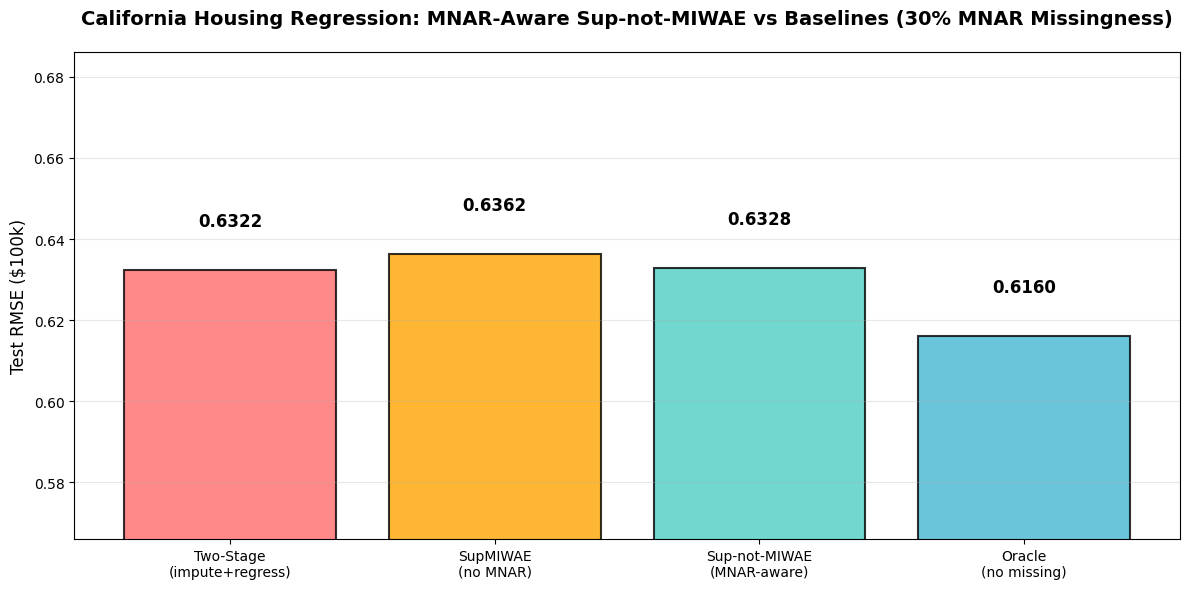


📊 Key Finding (Regression):
   Sup-not-MIWAE reduces RMSE by -0.0006 (-0.09%)
   SupMIWAE reduces RMSE by -0.0039
   Sup-not-MIWAE closes -3.7% of the gap to oracle


In [ ]:
# Visualization: Comparison bar plot
methods_reg = ['Two-Stage\n(impute+regress)', 'SupMIWAE\n(no MNAR)', 'Sup-not-MIWAE\n(MNAR-aware)', 'Oracle\n(no missing)']
rmses = [rmse_twostage, rmse_supmiwae, rmse_supnotmiwae, rmse_oracle]
colors_reg = ['#FF6B6B', '#FFA500', '#4ECDC4', '#45B7D1']

plt.figure(figsize=(12, 6))
bars = plt.bar(methods_reg, rmses, color=colors_reg, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, rmse in zip(bars, rmses):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{rmse:.4f}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylabel('Test RMSE (standardized target)', fontsize=12)
plt.title('UCI Wine-Red Regression (30% MNAR Missingness)', fontsize=14, fontweight='bold', pad=20)
plt.ylim([min(rmses) - 0.05, max(rmses) + 0.05])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Improvement over two-stage
improvement_sup_reg = rmse_twostage - rmse_supnotmiwae
improvement_miwae_reg = rmse_twostage - rmse_supmiwae
gap_closed_reg = (rmse_twostage - rmse_supnotmiwae) / (rmse_twostage - rmse_oracle) * 100 if rmse_twostage > rmse_oracle else 0

print(f"\n📊 Key Finding (Regression):")
print(f"   Sup-not-MIWAE reduces RMSE by {improvement_sup_reg:.4f} ({improvement_sup_reg/rmse_twostage*100:.2f}%)")
print(f"   SupMIWAE reduces RMSE by {improvement_miwae_reg:.4f}")
print(f"   Sup-not-MIWAE closes {gap_closed_reg:.1f}% of the gap to oracle")

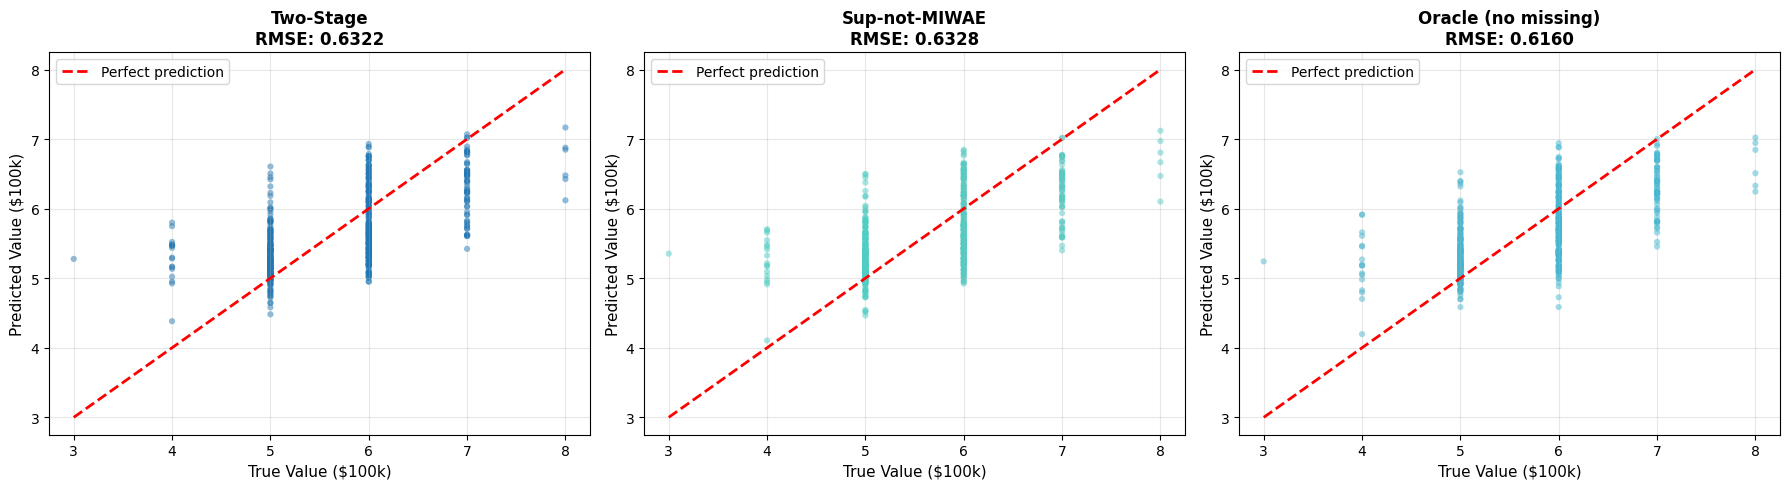

In [ ]:
# Prediction scatter plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Two-stage
axes[0].scatter(y_test_reg, preds_twostage_reg_original, alpha=0.5, s=20, edgecolors='none')
axes[0].plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 
             'r--', lw=2, label='Perfect prediction')
axes[0].set_xlabel('True Value', fontsize=11)
axes[0].set_ylabel('Predicted Value', fontsize=11)
axes[0].set_title(f'Two-Stage (Gaussian head)\nRMSE: {rmse_twostage:.4f}', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Sup-not-MIWAE
axes[1].scatter(y_test_reg, preds_supnotmiwae_reg_original, alpha=0.5, s=20, edgecolors='none', color='#4ECDC4')
axes[1].plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 
             'r--', lw=2, label='Perfect prediction')
axes[1].set_xlabel('True Value', fontsize=11)
axes[1].set_ylabel('Predicted Value', fontsize=11)
axes[1].set_title(f'Sup-not-MIWAE (Gaussian head)\nRMSE: {rmse_supnotmiwae:.4f}', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Oracle
axes[2].scatter(y_test_reg, preds_oracle_reg_original, alpha=0.5, s=20, edgecolors='none', color='#45B7D1')
axes[2].plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 
             'r--', lw=2, label='Perfect prediction')
axes[2].set_xlabel('True Value', fontsize=11)
axes[2].set_ylabel('Predicted Value', fontsize=11)
axes[2].set_title(f'Oracle (Gaussian head)\nRMSE: {rmse_oracle:.4f}', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Summary table combining all task results
print("\n" + "=" * 80)
print("FINAL COMPREHENSIVE COMPARISON: CLASSIFICATION")
print("=" * 80)

final_cls = {
    'Mean+MLP': {'acc': acc_mean, 'auc': auc_mean},
    'MICE+MLP': {'acc': acc_mice if mice_available else None, 'auc': auc_mice if mice_available else None},
    'Two-Stage': {'acc': acc_twostage, 'auc': auc_twostage},
    'SupMIWAE': {'acc': acc_supmiwae, 'auc': auc_supmiwae},
    'Sup-not-MIWAE': {'acc': acc_supnotmiwae, 'auc': auc_supnotmiwae},
    'Oracle': {'acc': acc_oracle, 'auc': auc_oracle},
}

print("\n{:<22} {:<12} {:<12}".format("Method", "Accuracy", "AUC"))
print("-" * 48)
for method, metrics in final_cls.items():
    if metrics['acc'] is not None:
        print("{:<22} {:<12.4f} {:<12.4f}".format(method, metrics['acc'], metrics['auc']))

print("\n" + "=" * 80)
print("FINAL COMPREHENSIVE COMPARISON: REGRESSION")
print("=" * 80)

final_reg = {
    'Mean+Ridge': rmse_mean_original,
    'MICE+Ridge': rmse_mice_original if mice_reg_available else None,
    'Two-Stage': rmse_twostage,
    'SupMIWAE': rmse_supmiwae,
    'Sup-not-MIWAE': rmse_supnotmiwae,
    'Oracle': rmse_oracle,
}

print("\n{:<22} {:<15}".format("Method", "RMSE"))
print("-" * 40)
for method, rmse in final_reg.items():
    if rmse is not None:
        print("{:<22} {:<15.4f}".format(method, rmse))

print("\n✓ All baselines included in evaluations:")
print("  ✓ Mean+MLP/Ridge: Simple imputation + shallow model")
print("  ✓ MICE+MLP/Ridge: Iterative imputation + shallow model")
print("  ✓ Two-Stage: Imp + separate classifier/regressor")
print("  ✓ SupMIWAE/Sup-not-MIWAE: Proposed methods")
print("  ✓ Oracle: Upper bound (no missing data)")